In [8]:
# importing libraries
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [9]:
# FER standard dataset imported from my google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [11]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [12]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

In [13]:
# changing the data type of the array elements
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [14]:
X_train[0]

array([ 70,  80,  82, ..., 106, 109,  82], dtype=uint8)

In [15]:
import keras
from keras.utils import to_categorical
#categorizing the data
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
print(y_train)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [17]:
# resizing image size to 48x48 , could be changed later according to requirements
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


In [18]:
print(X_train)
print(X_test)

[[[[ 70]
   [ 80]
   [ 82]
   ...
   [ 52]
   [ 43]
   [ 41]]

  [[ 65]
   [ 61]
   [ 58]
   ...
   [ 56]
   [ 52]
   [ 44]]

  [[ 50]
   [ 43]
   [ 54]
   ...
   [ 49]
   [ 56]
   [ 47]]

  ...

  [[ 91]
   [ 65]
   [ 42]
   ...
   [ 72]
   [ 56]
   [ 43]]

  [[ 77]
   [ 82]
   [ 79]
   ...
   [105]
   [ 70]
   [ 46]]

  [[ 77]
   [ 72]
   [ 84]
   ...
   [106]
   [109]
   [ 82]]]


 [[[151]
   [150]
   [147]
   ...
   [129]
   [140]
   [120]]

  [[151]
   [149]
   [149]
   ...
   [122]
   [141]
   [137]]

  [[151]
   [151]
   [156]
   ...
   [109]
   [123]
   [146]]

  ...

  [[188]
   [188]
   [121]
   ...
   [185]
   [185]
   [186]]

  [[188]
   [187]
   [196]
   ...
   [186]
   [182]
   [187]]

  [[186]
   [184]
   [185]
   ...
   [193]
   [183]
   [184]]]


 [[[231]
   [212]
   [156]
   ...
   [ 44]
   [ 27]
   [ 16]]

  [[229]
   [175]
   [148]
   ...
   [ 27]
   [ 35]
   [ 27]]

  [[214]
   [156]
   [157]
   ...
   [ 28]
   [ 22]
   [ 28]]

  ...

  [[241]
   [245]
   [250]
   

In [19]:
# data augmentation 
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64


In [20]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

In [21]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from keras.layers import Concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [22]:
# this is a implementation of pre existing architecture 
def First_Model(input_shape=(48,48,1)):
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [23]:
model = First_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
num_epochs = 100  
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

<ipython-input-24-6e64a3a0b9bb>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,


Epoch 1/100
448/448 [==============================] - 54s 94ms/step - loss: 2.0419 - accuracy: 0.2144 - val_loss: 1.8988 - val_accuracy: 0.1931
Epoch 2/100
448/448 [==============================] - 40s 89ms/step - loss: 1.7892 - accuracy: 0.2545 - val_loss: 1.7818 - val_accuracy: 0.2758
Epoch 3/100
448/448 [==============================] - 40s 89ms/step - loss: 1.7463 - accuracy: 0.2836 - val_loss: 1.7699 - val_accuracy: 0.3129
Epoch 4/100
448/448 [==============================] - 40s 89ms/step - loss: 1.6867 - accuracy: 0.3233 - val_loss: 1.6692 - val_accuracy: 0.3566
Epoch 5/100
448/448 [==============================] - 40s 89ms/step - loss: 1.6150 - accuracy: 0.3663 - val_loss: 1.7089 - val_accuracy: 0.3703
Epoch 6/100
448/448 [==============================] - 40s 89ms/step - loss: 1.5455 - accuracy: 0.3949 - val_loss: 1.5918 - val_accuracy: 0.4107
Epoch 7/100
448/448 [==============================] - 40s 89ms/step - loss: 1.4836 - accuracy: 0.4225 - val_loss: 1.5840 - val_ac

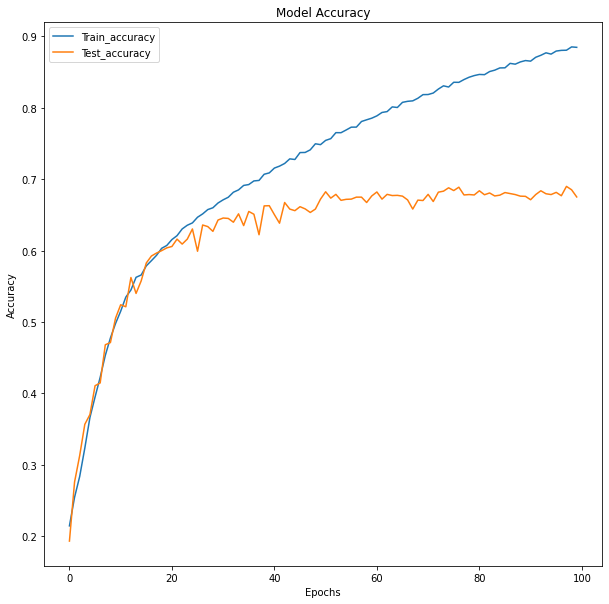

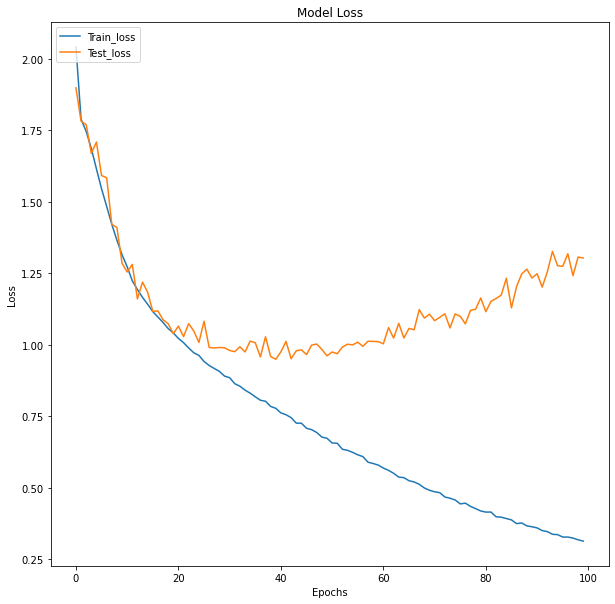

In [25]:
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# the above model has been over trained , so will train once agiain for 25-30 epochs and try other architectures like vgg and resnet .